In [1]:
import numpy as np

# The refnx library
import refnx
from refnx.reflect import structure, ReflectModel, SLD
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter

# The periodictable library for scattering lengths
import periodictable as pt

# The mquantiles library to determined confidence intervals
import scipy
from scipy.stats.mstats import mquantiles

# The custom class to constain the monolayer model. 
import sys
sys.path.insert(0, '../../models')
import mol_vol_mod as mv

In [2]:
# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.1.1.dev0+6251c23', '1.1.0')

In [3]:
surface_pressure = '30'#sys.argv[1]
if surface_pressure == '20':
    apm = 47.9
elif surface_pressure == '30':
    apm = 46.4
elif surface_pressure == '40':
    apm = 45.0
elif surface_pressure == '50':
    apm = 44.58
data_dir = '../../data/experimental/'

In [4]:
d13acmw_ds = ReflectDataset('{}surf_pres_{}/d13acmw{}.dat'.format(data_dir, surface_pressure, surface_pressure))
d70acmw_ds = ReflectDataset('{}surf_pres_{}/d70acmw{}.dat'.format(data_dir, surface_pressure, surface_pressure))
d83acmw_ds = ReflectDataset('{}surf_pres_{}/d83acmw{}.dat'.format(data_dir, surface_pressure, surface_pressure))
d13d2o_ds = ReflectDataset('{}surf_pres_{}/d13d2o{}.dat'.format(data_dir, surface_pressure, surface_pressure))
d70d2o_ds = ReflectDataset('{}surf_pres_{}/d70d2o{}.dat'.format(data_dir, surface_pressure, surface_pressure))
d83d2o_ds = ReflectDataset('{}surf_pres_{}/d83d2o{}.dat'.format(data_dir, surface_pressure, surface_pressure))
hd2o_ds = ReflectDataset('{}surf_pres_{}/hd2o{}.dat'.format(data_dir, surface_pressure, surface_pressure))

In [5]:
d70_head1 = {'C': 5, 'H': 13, 'O': 4, 'N': 1, 'P': 1}
d13_head1 = {'C': 5, 'D': 13, 'O': 4, 'N': 1, 'P': 1}
h_head1 = {'C': 5, 'H': 13, 'O': 4, 'N': 1, 'P': 1}
d83_head1 = {'C': 5, 'D': 13, 'O': 4, 'N': 1, 'P': 1}
d70_head2 = {'C': 5, 'D': 5, 'O': 4}
d13_head2 = {'C': 5, 'H': 5, 'O': 4}
h_head2 = {'C': 5, 'H': 5, 'O': 4}
d83_head2 = {'C': 5, 'D': 5, 'O': 4}
h_tail = {'C': 34, 'H': 70}
d_tail = {'C': 34, 'D': 70}

In [6]:
d70h1 = mv.get_scattering_length(d70_head1)
d13h1 = mv.get_scattering_length(d13_head1)
hh1 = mv.get_scattering_length(h_head1)
d83h1 = mv.get_scattering_length(d83_head1)
d70h2 = mv.get_scattering_length(d70_head2)
d13h2 = mv.get_scattering_length(d13_head2)
hh2 = mv.get_scattering_length(h_head2)
d83h2 = mv.get_scattering_length(d83_head2)
ht = mv.get_scattering_length(h_tail)
dt = mv.get_scattering_length(d_tail)

In [7]:
tail_length = 1.54 + 1.265 * 17
head_thick1 = 7.
head_thick2 = 7.
chain_tilt = 0.82
head_mol_vol1 = 200
head_mol_vol2 = 140
tail_mol_vol = 900

In [8]:
d13 = mv.VolMono(d13h1, head_thick1, d13h2, head_thick2, ht, tail_length, 
                 chain_tilt, [head_mol_vol1, head_mol_vol2, tail_mol_vol], name='d13-lipid')
d70 = mv.VolMono(d70h1, head_thick1, d70h2, head_thick2, dt, tail_length, 
                 chain_tilt, [head_mol_vol1, head_mol_vol2, tail_mol_vol], name='d70-lipid')
d83 = mv.VolMono(d83h1, head_thick1, d83h2, head_thick2, dt, tail_length, 
                 chain_tilt, [head_mol_vol1, head_mol_vol2, tail_mol_vol], name='d83-lipid')
h = mv.VolMono(hh1, head_thick1, hh2, head_thick2, ht, tail_length, 
               chain_tilt, [head_mol_vol1, head_mol_vol2, tail_mol_vol], name='h-lipid')

In [9]:
air = SLD(0., 'air')
acmw = SLD(0., 'acmw')
d2o = SLD(6.35, 'd2o')

In [10]:
d13acmw = air(0, 0) | d13 | acmw(0, 3.3)
d70acmw = air(0, 0) | d70 | acmw(0, 3.3)
d83acmw = air(0, 0) | d83 | acmw(0, 3.3)
d13d2o = air(0, 0) | d13 | d2o(0, 3.3)
d70d2o = air(0, 0) | d70 | d2o(0, 3.3)
d83d2o = air(0, 0) | d83 | d2o(0, 3.3)
hd2o = air(0, 0) | h | d2o(0, 3.3)

In [11]:
def get_value(file, simtrad):
    f = open('../../output/' + simtrad + '/' + file + '.txt', 'r')
    for line in f:
        k = line
    l = k.split('$')[1]
    m = l.split('^')[0]
    return float(m)

In [12]:
d13.phih1.setp(0.5, vary=True, bounds=(0.5, 0.999))
d13.head_mol_vol1.setp(200, vary=True, bounds=(50, 300))
d13.thick_heads1.constraint = d13.head_mol_vol1 / (apm * (1 - d13.phih1))
d13.phih2.setp(0.5, vary=True, bounds=(0.1, 0.999))
d13.head_mol_vol2.setp(200, vary=True, bounds=(50, 300))
d13.thick_heads2.constraint = d13.head_mol_vol2 / (apm * (1 - d13.phih2))
d13.cos_rad_chain_tilt.setp(np.cos(np.deg2rad(get_value('angle_{}'.format(surface_pressure), 
                                   'traditional'))), vary=True, bounds=(0.01, 0.99))
d13.phit.setp(vary=False)
d13.rough_head_tail.setp(get_value('roughness_{}'.format(surface_pressure), 'traditional'), vary=True, bounds=(2., 5))
d13.rough_preceding_mono.constraint = d13.rough_head_tail
d13.tail_mol_vol.constraint = d13.cos_rad_chain_tilt * tail_length * apm
d13acmw[-1].rough.constraint = d13.rough_head_tail

In [13]:
structures = [d13acmw, d70acmw, d83acmw, d13d2o, d70d2o, d83d2o, hd2o]
lipids = [d13, d70, d83, h]

lipids, structures = mv.set_constraints(lipids, structures)

In [14]:
model_d13acmw = ReflectModel(d13acmw)
model_d13acmw.scale.setp(vary=True, bounds=(0.005, 10))
model_d13acmw.bkg.setp(d13acmw_ds.y[-1], vary=False)

model_d70acmw = ReflectModel(d70acmw)
model_d70acmw.scale.setp(vary=True, bounds=(0.005, 10))
model_d70acmw.bkg.setp(d70acmw_ds.y[-1], vary=False)

model_d83acmw = ReflectModel(d83acmw)
model_d83acmw.scale.setp(vary=True, bounds=(0.005, 10))
model_d83acmw.bkg.setp(d83acmw_ds.y[-1], vary=False)

model_d13d2o = ReflectModel(d13d2o)
model_d13d2o.scale.setp(vary=True, bounds=(0.005, 10))
model_d13d2o.bkg.setp(d13d2o_ds.y[-1], vary=False)

model_d70d2o = ReflectModel(d70d2o)
model_d70d2o.scale.setp(vary=True, bounds=(0.005, 10))
model_d70d2o.bkg.setp(d70d2o_ds.y[-1], vary=False)

model_d83d2o = ReflectModel(d83d2o)
model_d83d2o.scale.setp(vary=True, bounds=(0.005, 10))
model_d83d2o.bkg.setp(d83d2o_ds.y[-1], vary=False)

model_hd2o = ReflectModel(hd2o)
model_hd2o.scale.setp(vary=True, bounds=(0.005, 10))
model_hd2o.bkg.setp(hd2o_ds.y[-1], vary=False)

In [15]:
objective_d13acmw = Objective(model_d13acmw, d13acmw_ds, transform=Transform('YX4'))
objective_d70acmw = Objective(model_d70acmw, d70acmw_ds, transform=Transform('YX4'))
objective_d83acmw = Objective(model_d83acmw, d83acmw_ds, transform=Transform('YX4'))
objective_d13d2o = Objective(model_d13d2o, d13d2o_ds, transform=Transform('YX4'))
objective_d70d2o = Objective(model_d70d2o, d70d2o_ds, transform=Transform('YX4'))
objective_d83d2o = Objective(model_d83d2o, d83d2o_ds, transform=Transform('YX4'))
objective_hd2o = Objective(model_hd2o, hd2o_ds, transform=Transform('YX4'))

global_objective = GlobalObjective([objective_d13acmw, objective_d70acmw, objective_d83acmw, 
                                    objective_d13d2o, objective_d70d2o, objective_d83d2o, objective_hd2o])

In [16]:
fitter = CurveFitter(global_objective)
res = fitter.fit('differential_evolution', seed=1)

In [17]:
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 140395264821792
Dataset = d13acmw30
datapoints = 51
chi2 = 567.5402594168685
Weighted = True
Transform = <refnx.analysis.objective.Transform object at 0x7fb051e34908>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    value=    3.57452     +/- 0.263, bounds=[0.005, 10]>
<Parameter:     'bkg'     value=  1.2229e-06    (fixed)  , bounds=[-inf, inf]>
<Parameter:'dq - resolution'value=       5        (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________

567.5402594168685


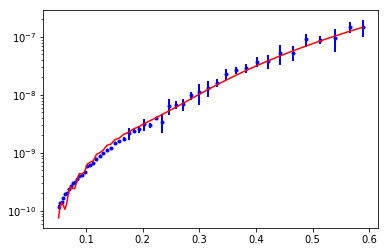

408.99118055962765


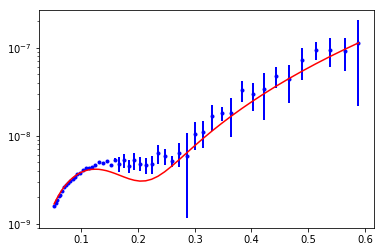

417.0778414630202


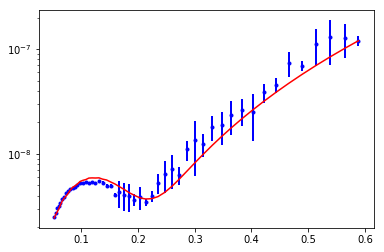

340.5751017324317


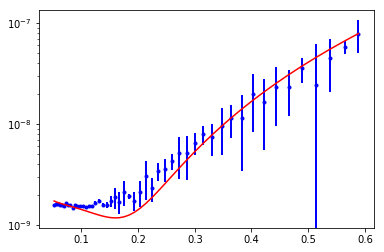

1826.2527627951063


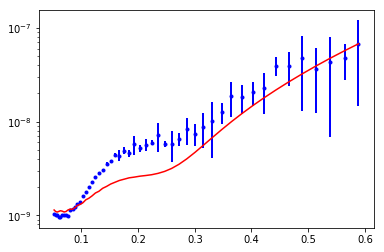

652.0002718924394


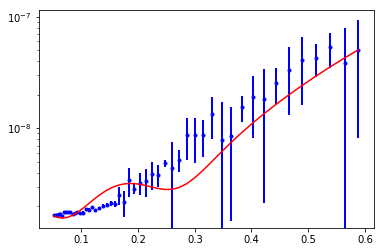

107.74872942064275


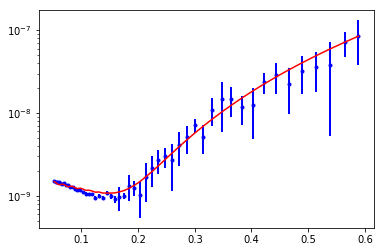

617.169449611448 518.9202316506411


In [18]:
import matplotlib.pyplot as plt

tot = []
for i in global_objective.objectives:
    print(i.chisqr())
    i.plot()
    plt.yscale('log')
    tot.append(i.chisqr())
    plt.show()
print(np.array(tot).mean(), np.array(tot).std())

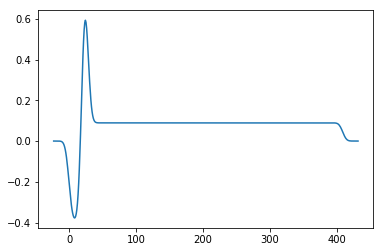

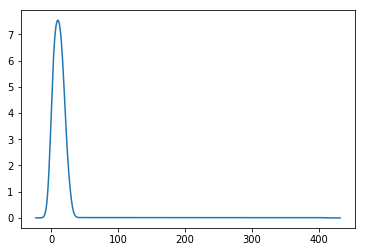

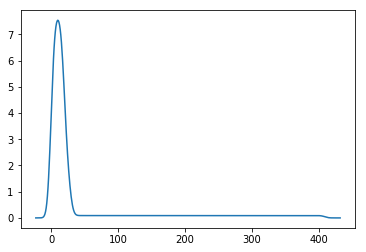

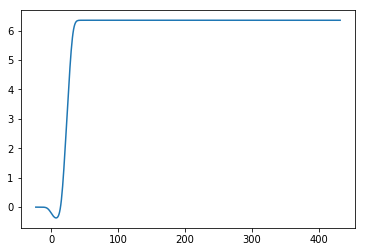

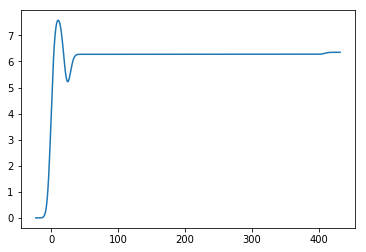

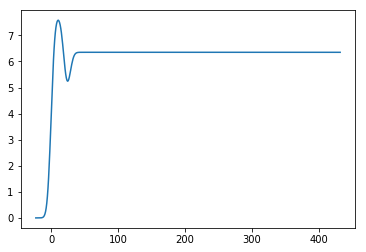

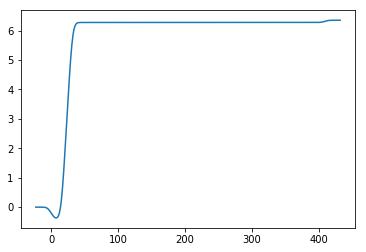

In [19]:
for i in structures:
    plt.plot(i.sld_profile()[0], i.sld_profile()[1])
    plt.show()

In [ ]:
m = 200
n = 1000

fitter.sample(m, random_state=1)
fitter.sampler.reset()
res = fitter.sample(n, nthin=1, random_state=1)
flatchain = fitter.sampler.flatchain

In [ ]:
print(global_objective)

In [ ]:
def wph(phih, vh):
    return phih * vh / (29.9 - 29.9 * phih)

In [ ]:
copychain = np.array(flatchain)

In [ ]:
labels = ['scale1', 'vh1', 'phi2', 'scale2', 'scale3', 
          'scale4', 'scale5', 'scale6', 'scale7']
for k, label in enumerate(labels):
    file_out = open('../../output/traditional/{}_{}_mod.txt'.format(label, surface_pressure), 'w')
    a = mquantiles(copychain[:, k], prob=[0.025, 0.5, 0.975])
    k = [a[1], a[1] - a[0], a[2] - a[1]]
    q = '{:.2f}'.format(k[0])
    e = '{:.2f}'.format(k[1])
    w = '{:.2f}'.format(k[2])
    file_out.write('$' + str(q) + '^{+' + str(w) + '}_{-' + str(e) + '}$')
    file_out.close()

In [ ]:
headvol1 = copychain[:, 1]
headvol2 = get_value('vh_{}'.format(surface_pressure), 'traditional') - copychain[:, 1]
phih2 = copychain[:, 2]
theads2 = (headvol2 * d13.tail_length.value * d13.cos_rad_chain_tilt.value) / (d13.tail_mol_vol.value * (1 - phih2))
theads1 = get_value('dh_{}'.format(surface_pressure), 'traditional') - theads2
phih1 = 1 - (headvol1 * theads2 * (1 - phih2) / (headvol2 * theads1))
labels = ['wph1', 'wph2']
phih = np.array([phih1, phih2])
hv = np.array([headvol1, headvol2])
wphs = wph(phih, hv)

In [ ]:
for k, label in enumerate(labels):
    file_out = open('../../output/traditional/{}_{}_mod.txt'.format(label, surface_pressure), 'w')
    a = mquantiles(wphs[k, :], prob=[0.025, 0.5, 0.975])
    k = [a[1], a[1] - a[0], a[2] - a[1]]
    q = '{:.2f}'.format(k[0])
    e = '{:.2f}'.format(k[1])
    w = '{:.2f}'.format(k[2])
    file_out.write('$' + str(q) + '^{+' + str(w) + '}_{-' + str(e) + '}$')
    file_out.close()

In [ ]:
contrasts = ['d13acmw', 'd70acmw', 'd83acmw', 'd13d2o', 'd70d2o', 'd83d2o', 'hd2o']
for i, a in enumerate(global_objective.objectives):
    file_out = open('../../output/traditional/{}_{}_mod_chisq.txt'.format(contrasts[i], surface_pressure), 'w')
    file_out.write('${:.2f}$'.format(a.chisqr()))
    file_out.close()

In [ ]:
def custom_pgen(objective, ngen):
    chains = np.array([np.ravel(param.chain[..., 0::1]) for param
                           in objective.varying_parameters()
                           if param.chain is not None])

    if len(chains) != len(objective.varying_parameters()) or len(chains) == 0:
        raise ValueError("You need to perform sampling on all the varying"
                         "parameters first")

    samples = np.arange(np.size(chains, 1))
    
    np.random.seed(1)

    choices = np.random.choice(samples,
                               size=(min(ngen, samples.size),),
                               replace=False)

    for choice in choices:
        yield chains[..., choice]

In [ ]:
contrasts = ['d13acmw', 'd70acmw', 'd83acmw', 'd13d2o', 'd70d2o', 'd83d2o', 'hd2o']
models = [model_d13acmw, model_d70acmw, model_d83acmw, model_d13d2o, model_d70d2o, model_d83d2o, 
          model_hd2o]
datasets = [d13acmw_ds, d70acmw_ds, d83acmw_ds, d13d2o_ds, d70d2o_ds, d83d2o_ds, hd2o_ds]
for k, con in enumerate(contrasts):
    for obj in global_objective.objectives:
        if con in obj.data.name:
            ref_out = open('../../output/traditional/{}_{}_mod_ref.txt'.format(con, surface_pressure), 'w')
            for i in range(datasets[k].x.size):
                ref_out.write('{} {} {} '.format(datasets[k].x[i], datasets[k].y[i]*(datasets[k].x[i])**4, 
                                                 datasets[k].y_err[i]*(datasets[k].x[i])**4))
                choose = custom_pgen(global_objective, 100)
                for c in choose:
                    global_objective.setp(c)
                    ref_out.write('{} '.format(models[k](datasets[k].x[i])*(datasets[k].x[i])**4))
                ref_out.write('\n')
            ref_out.close()

In [ ]:
for i, struct in enumerate(structures):
    sld_out = open('../../output/traditional/{}_{}_mod_sld.txt'.format(contrasts[i], surface_pressure), 'w')
    for j in range(struct.sld_profile()[0].size):
        sld_out.write('{} '.format(struct.sld_profile()[0][j]))
        choose = custom_pgen(global_objective, 100)
        for c in choose:
            global_objective.setp(c)
            sld_out.write('{} '.format(struct.sld_profile()[1][j]))
        sld_out.write('\n')
    sld_out.close()